# STEP #1: 라이브러리 및 데이터셋 불러오기

In [31]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 

In [32]:
# 이미지 분류기를 위해 다양한 카테고리를 가진 cifar10 데이터셋 사용
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()


In [65]:
X_train.shape

(50000, 32, 32, 3)

In [66]:
X_test.shape

(10000, 32, 32, 3)

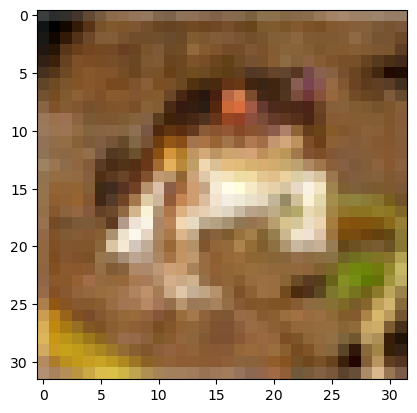

In [70]:
plt.imshow(X_train[0], cmap="gray")

# STEP #2: 데이터 이미지 출력

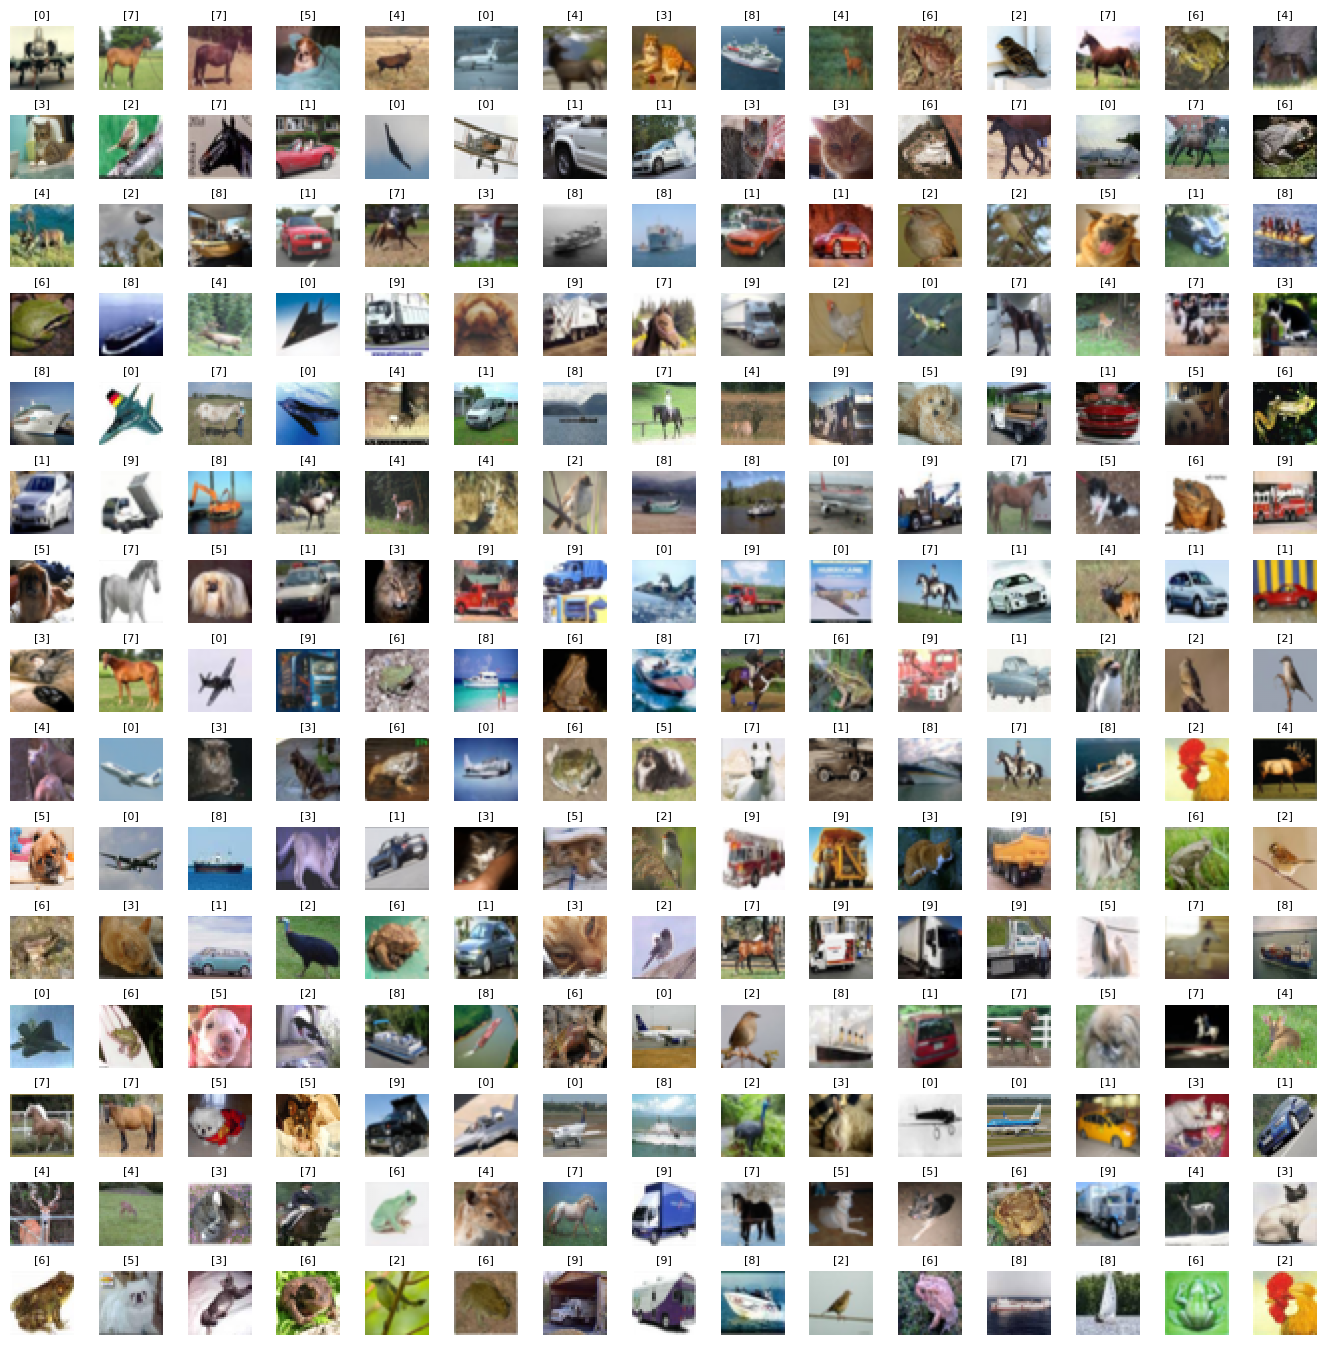

In [74]:
# 이미지 여러 개 출력
# 15 * 15 형식으로 출력
W_grid = 15
L_grid = 15

# subplots()함수 fig, axes 객체 리턴
fig, axes = plt.subplots(5, 5, figsize = (17,17))

# 15 * 15 행렬을 255크기의 배열로 바꿈
axes = axes.ravel() 

# 훈련용 데이터셋 크기 반환
n_training = len(X_train) 

# 0 ~ n_training 까지 중 랜덤한 인덱스의 데이터 이미지 출력
for i in np.arange(0, 5*5): 
    # 랜덤한 인덱스 지정
    index = np.random.randint(0, n_training)
    # 인덱스에 해당하는 데이터 이미지 출력
    axes[i].imshow( X_train[index] )
    axes[i].set_title(y_train[index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

# STEP #3: 이미지 노이즈 추가

In [76]:
X_train = X_train / 255
X_test = X_test / 255

In [75]:
# 노이즈 강도 0.3
noise_factor = 0.3

# 노이즈 추가된 이미지 저장할 배열
noise_dataset = []

# 훈련용 데이터 노이즈 추가
for img in X_train:
  noisy_image = img + noise_factor * np.random.randn(*img.shape) # 이미지 픽셀에 노이즈 추가
  noisy_image = np.clip(noisy_image, 0., 1.) # 이미지 클리핑
  noise_dataset.append(noisy_image) # 노이즈 추가된 이미지 noise_dataset 배열에 추가

noise_dataset = np.array(noise_dataset)
noise_dataset.shape

(50000, 32, 32, 3)

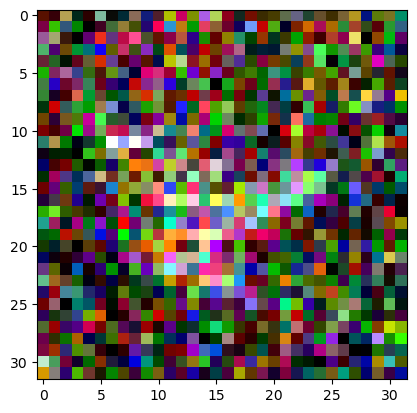

In [ ]:
# 노이즈 추가된 이미지 하나 임의 출력
plt.imshow(noise_dataset[22], cmap="gray")

In [ ]:
# 검증용 데이터 노이즈 추가
noise_test_set = []
for img in X_test:
  noisy_image = img + noise_factor * np.random.randn(*img.shape) # 이미지 픽셀에 노이즈 추가
  noisy_image = np.clip(noisy_image, 0., 1.) # 이미지 클리핑
  noise_test_set.append(noisy_image)  # 노이즈 추가된 이미지 noise_dataset 배열에 추가
  
noise_test_set = np.array(noise_test_set)
noise_test_set.shape

(10000, 32, 32, 3)

# STEP #4: 오토인코더 모델 설계 및 훈련(.fit())

In [ ]:
# 입력 이미지의 형태 저장
input_shape = X_train.shape[1:]

# 오토인코더 모델 생성
autoencoder = tf.keras.models.Sequential([
    ### 인코더 부분
    # 이미지 특성 추출
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    # 2x2 최대 풀링을 사용하여 이미지 크기를 1/2배 (차원 축소 및 압축)
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    # 이미지 특성 추출
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    
    ### 디코더 부분
    # 2x2 업샘플링을 사용하여 이미지 크기를 2배 (차원 복원 및 복원)
    tf.keras.layers.UpSampling2D((2, 2)),
    # 이미지 특성 추출
    tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])


In [ ]:
# 오토인코더 모델 컴파일
autoencoder.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001))
# 오토인코더 모델 요약 출력
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 up_sampling2d (UpSampling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 3)         867       
                                                                 
Total params: 11,011
Trainable params: 11,011
Non-trai

In [ ]:
# 데이터 훈련
autoencoder.fit(noise_dataset, X_train, epochs=10, batch_size=128, validation_data=(noise_test_set, X_test))

Epoch 1/10
391/391 [==============================] - 251s 643ms/step - loss: 0.5682 - val_loss: 0.5684
Epoch 2/10
391/391 [==============================] - 311s 796ms/step - loss: 0.5671 - val_loss: 0.5675
Epoch 3/10
391/391 [==============================] - 269s 687ms/step - loss: 0.5665 - val_loss: 0.5672
Epoch 4/10
391/391 [==============================] - 208s 531ms/step - loss: 0.5660 - val_loss: 0.5667
Epoch 5/10
391/391 [==============================] - 181s 464ms/step - loss: 0.5658 - val_loss: 0.5664
Epoch 6/10
391/391 [==============================] - 199s 508ms/step - loss: 0.5655 - val_loss: 0.5663
Epoch 7/10
391/391 [==============================] - 167s 426ms/step - loss: 0.5653 - val_loss: 0.5662
Epoch 8/10
391/391 [==============================] - 111s 283ms/step - loss: 0.5652 - val_loss: 0.5661
Epoch 9/10
391/391 [==============================] - 88s 224ms/step - loss: 0.5651 - val_loss: 0.5659
Epoch 10/10
391/391 [==============================] - 96s 246ms/

# STEP #5: 모델 성능 측정 및 노이즈 제거 예시 출력

In [ ]:
# 모델 성능 측정 (예측 정확도 파라미터)
evaluation = autoencoder.evaluate(noise_test_set, X_test)
print('Test Accuracy : {:.3f}'.format(evaluation))

313/313 [==============================] - 4s 14ms/step - loss: 0.5659
Test Accuracy : 0.566


In [ ]:
# 오토인코더 노이즈 제거 출력을 위한 예측 결과 저장
predicted = autoencoder.predict(noise_test_set[:10])

1/1 [==============================] - 0s 59ms/step


In [ ]:
predicted.shape

(10, 32, 32, 3)

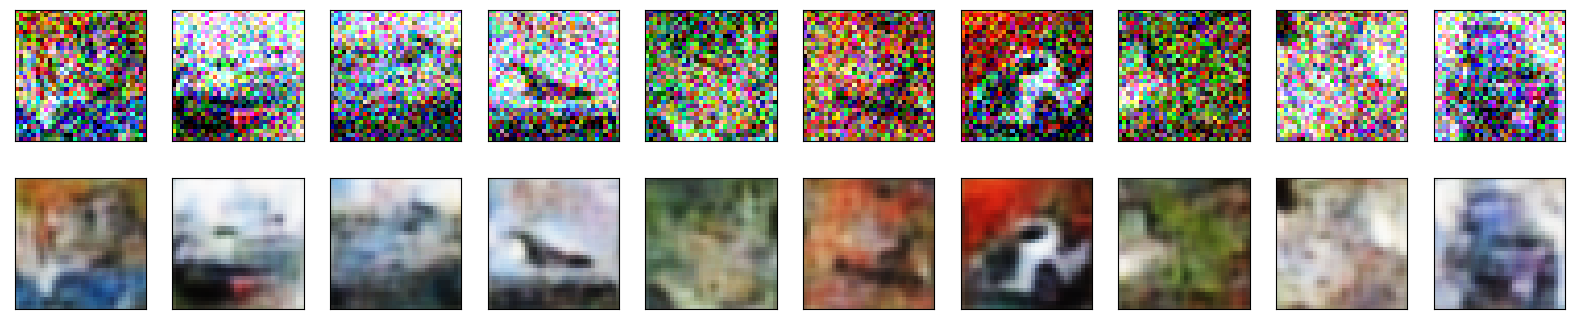

In [ ]:
# 예측 결과 출력
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
for images, row in zip([noise_test_set[:10], predicted], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((32, 32, 3)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)